<a href="https://colab.research.google.com/github/NandhithaMilkuri/Batch20_1352_PDS/blob/main/ProjectCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Training completed in 50.6s
RandomForest: R²=0.833, RMSE=0.261, MAE=0.208
XGBoost: R²=0.914, RMSE=0.188, MAE=0.147

Best Model Selected: XGBoost


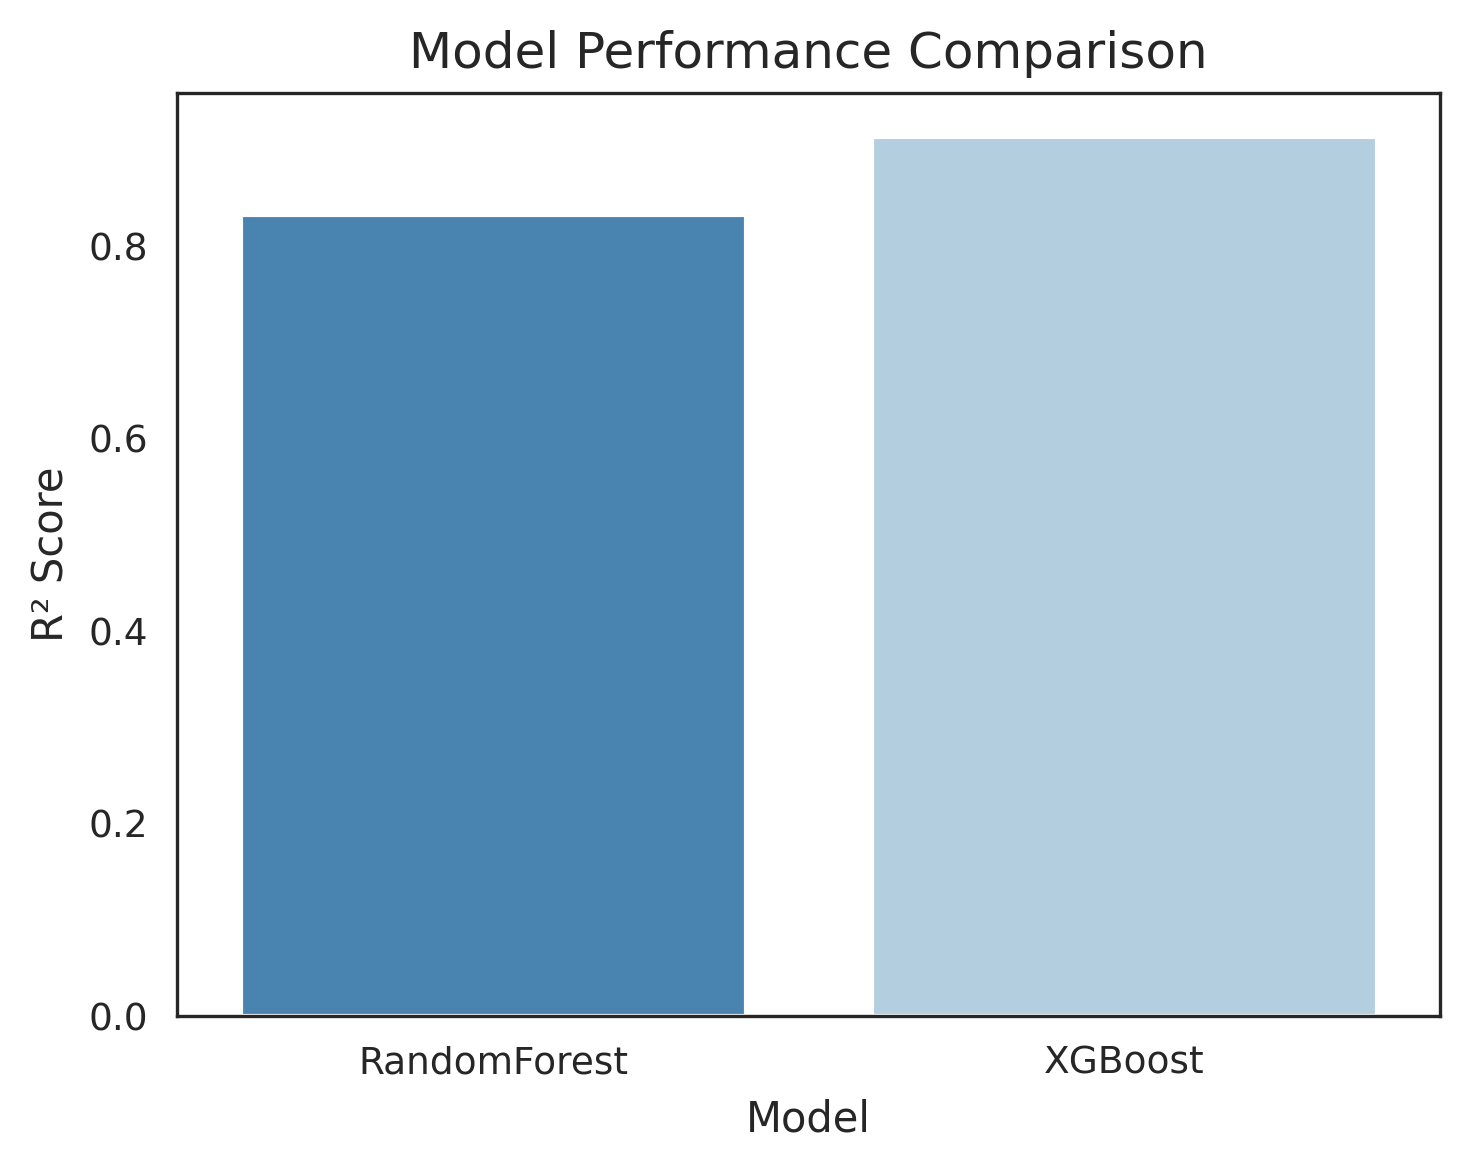

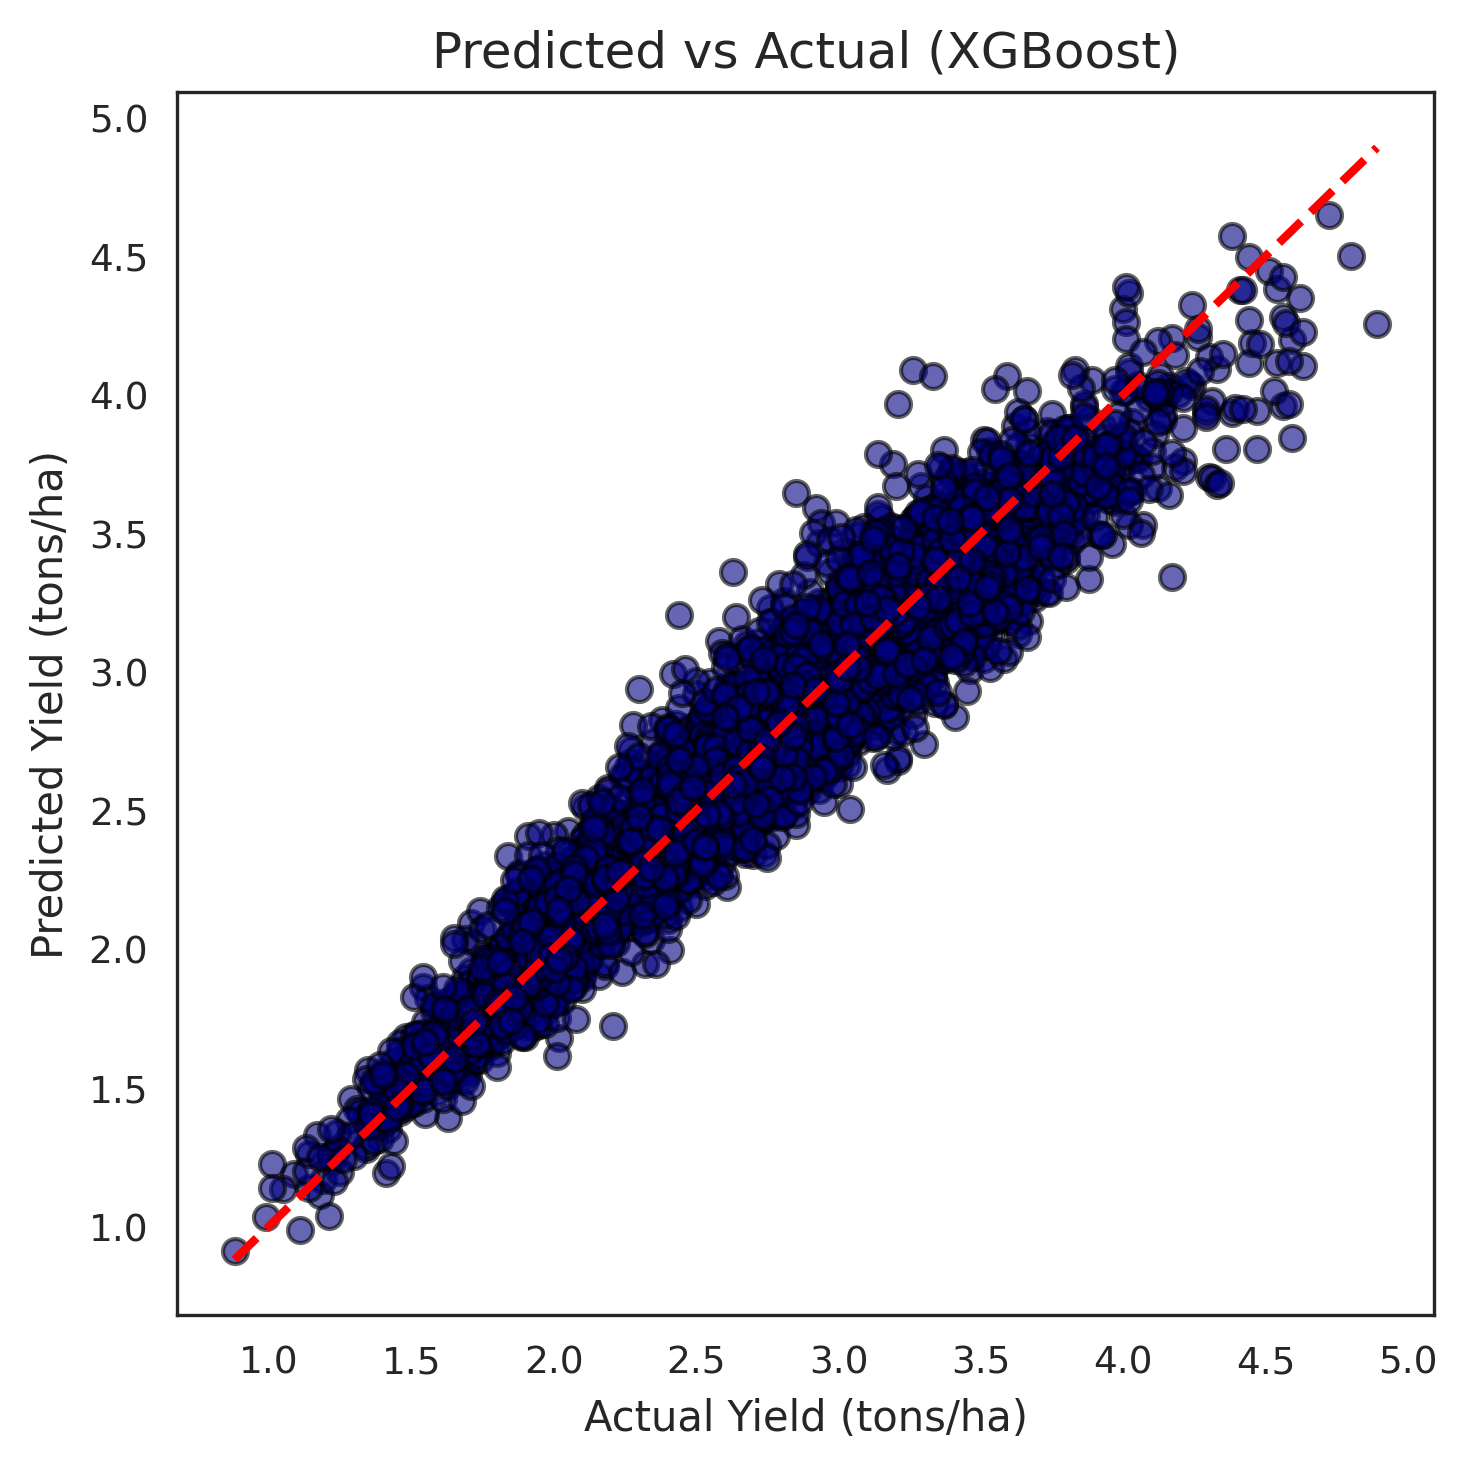

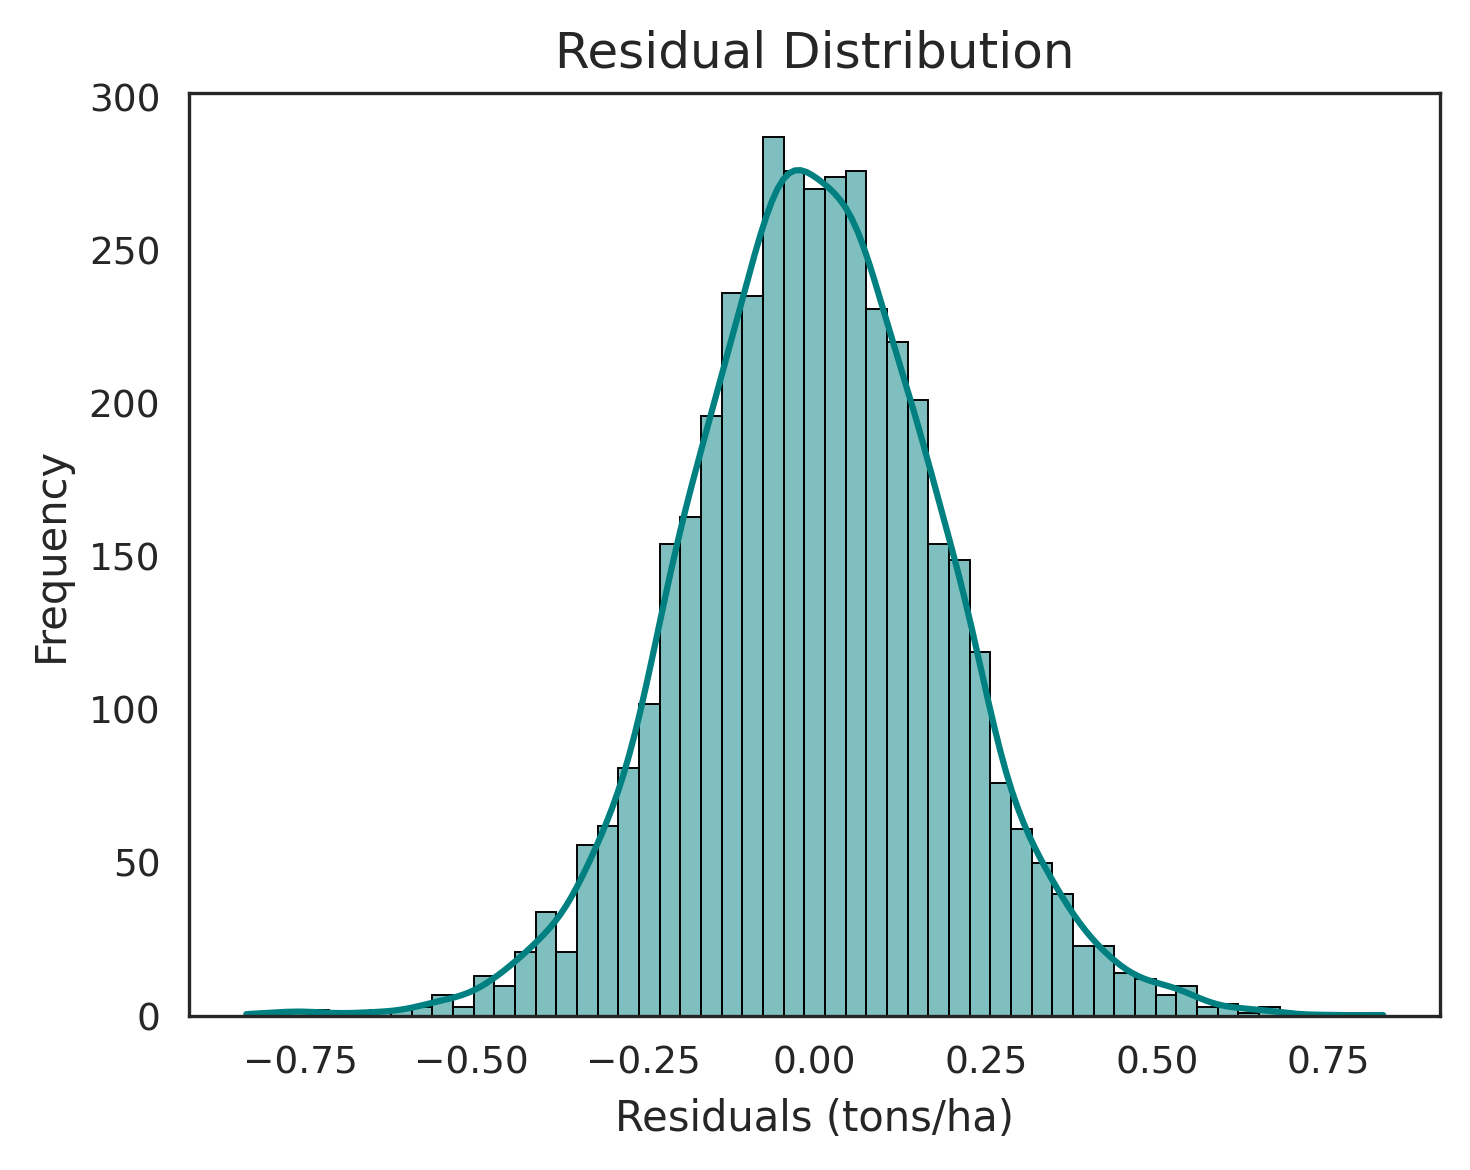

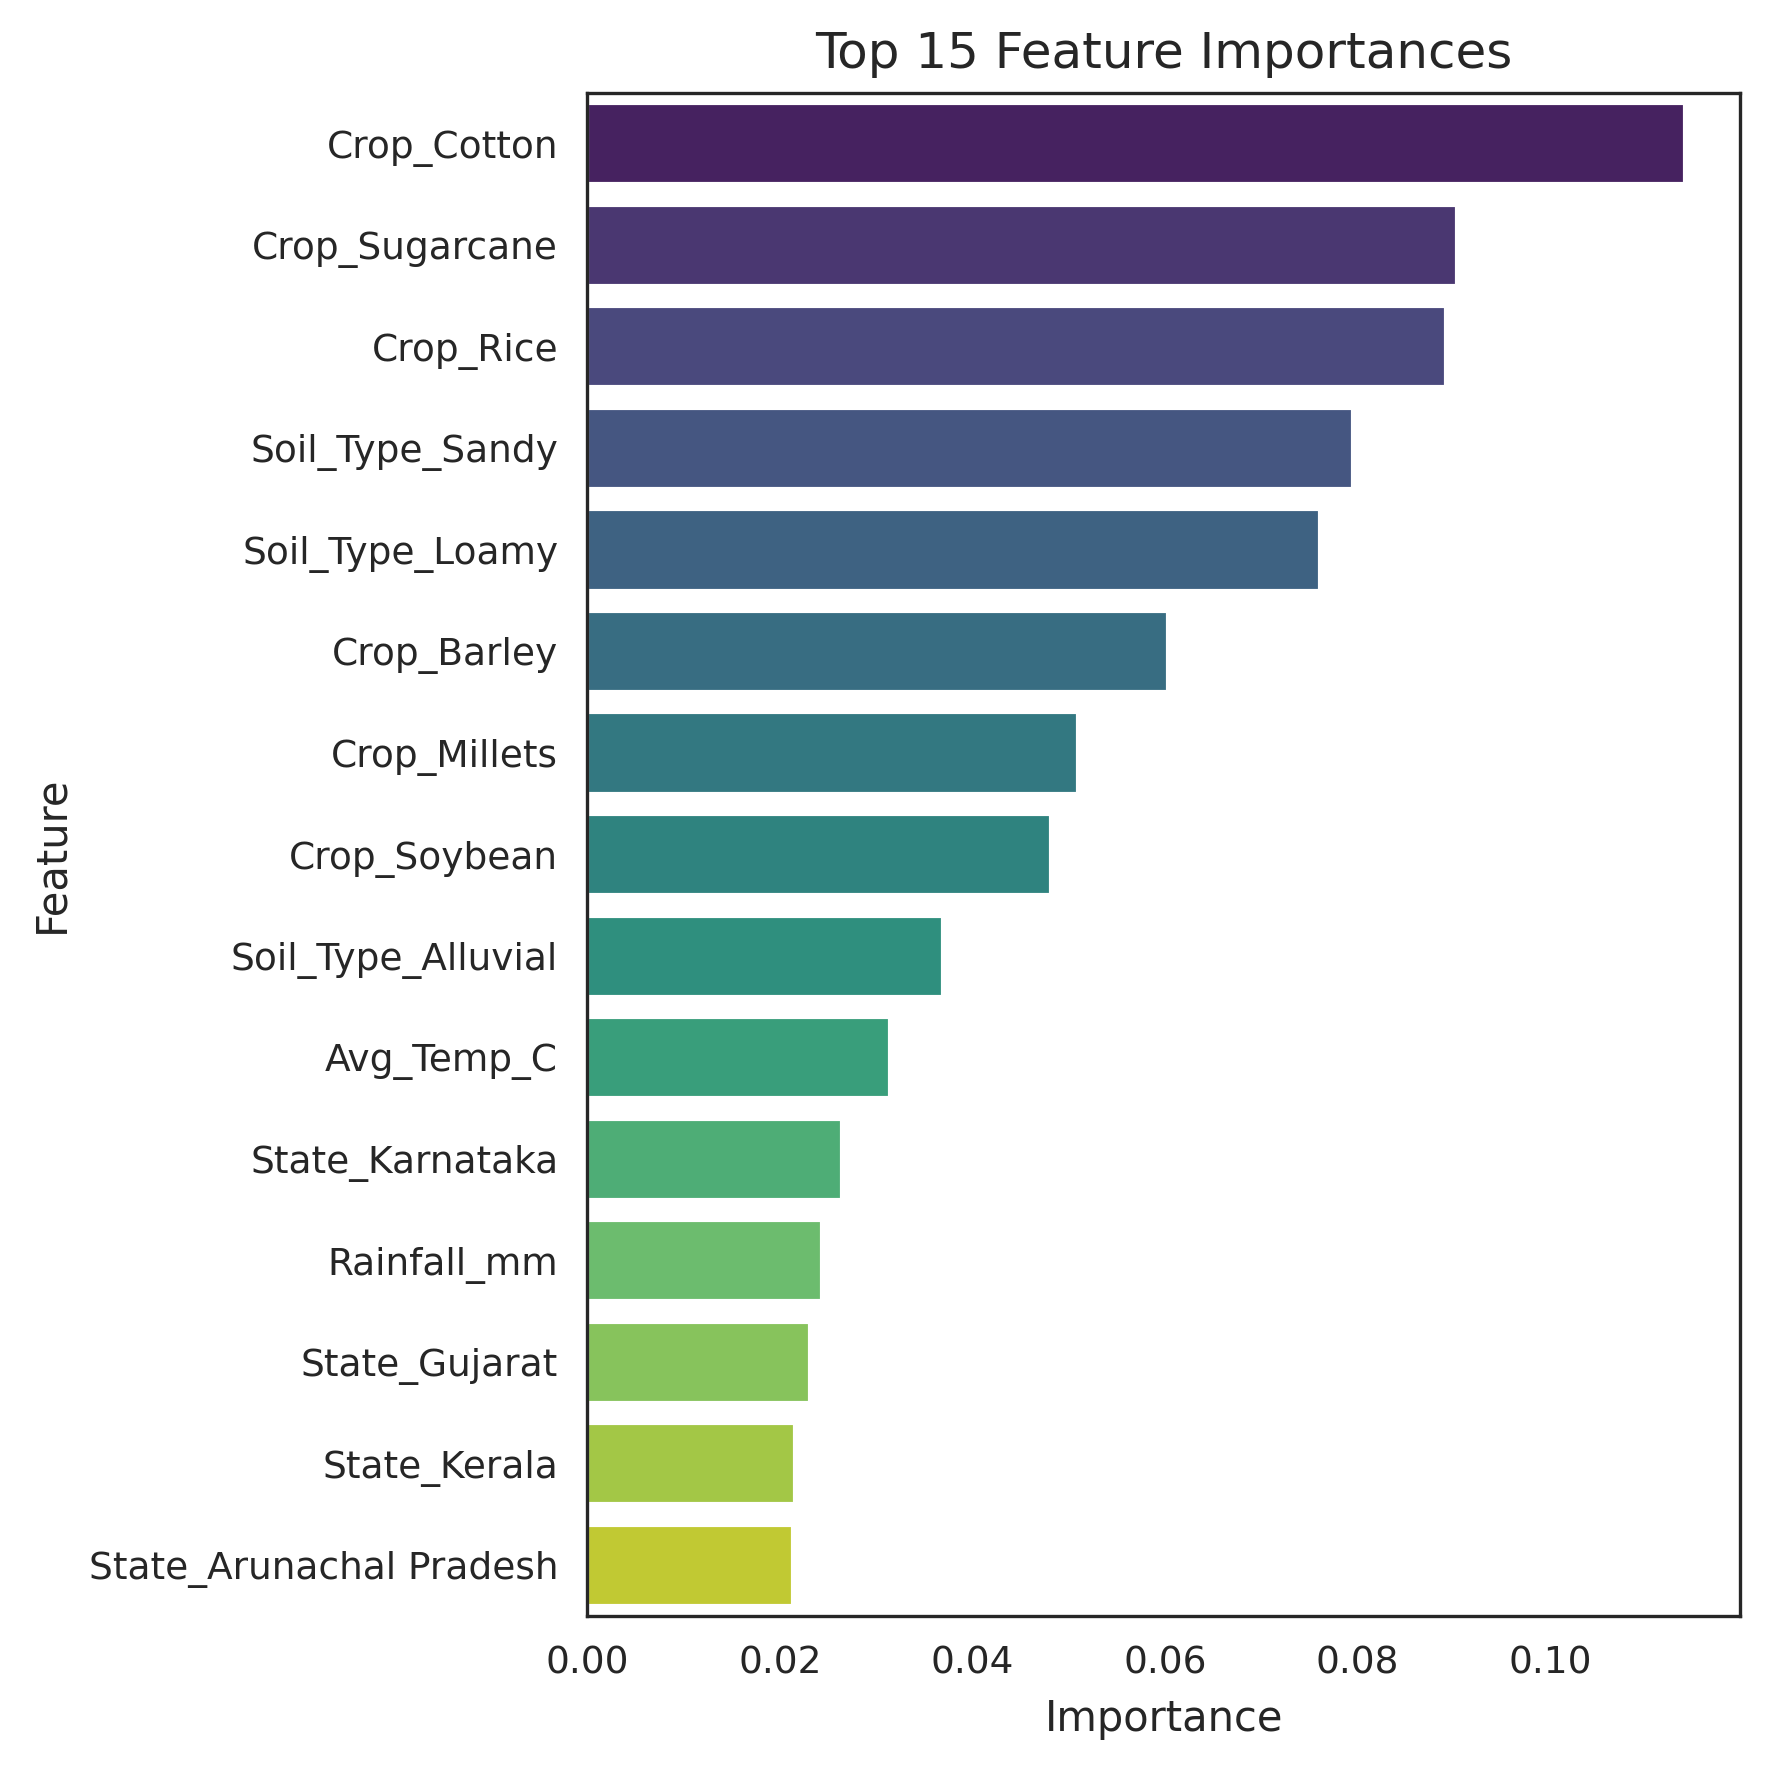

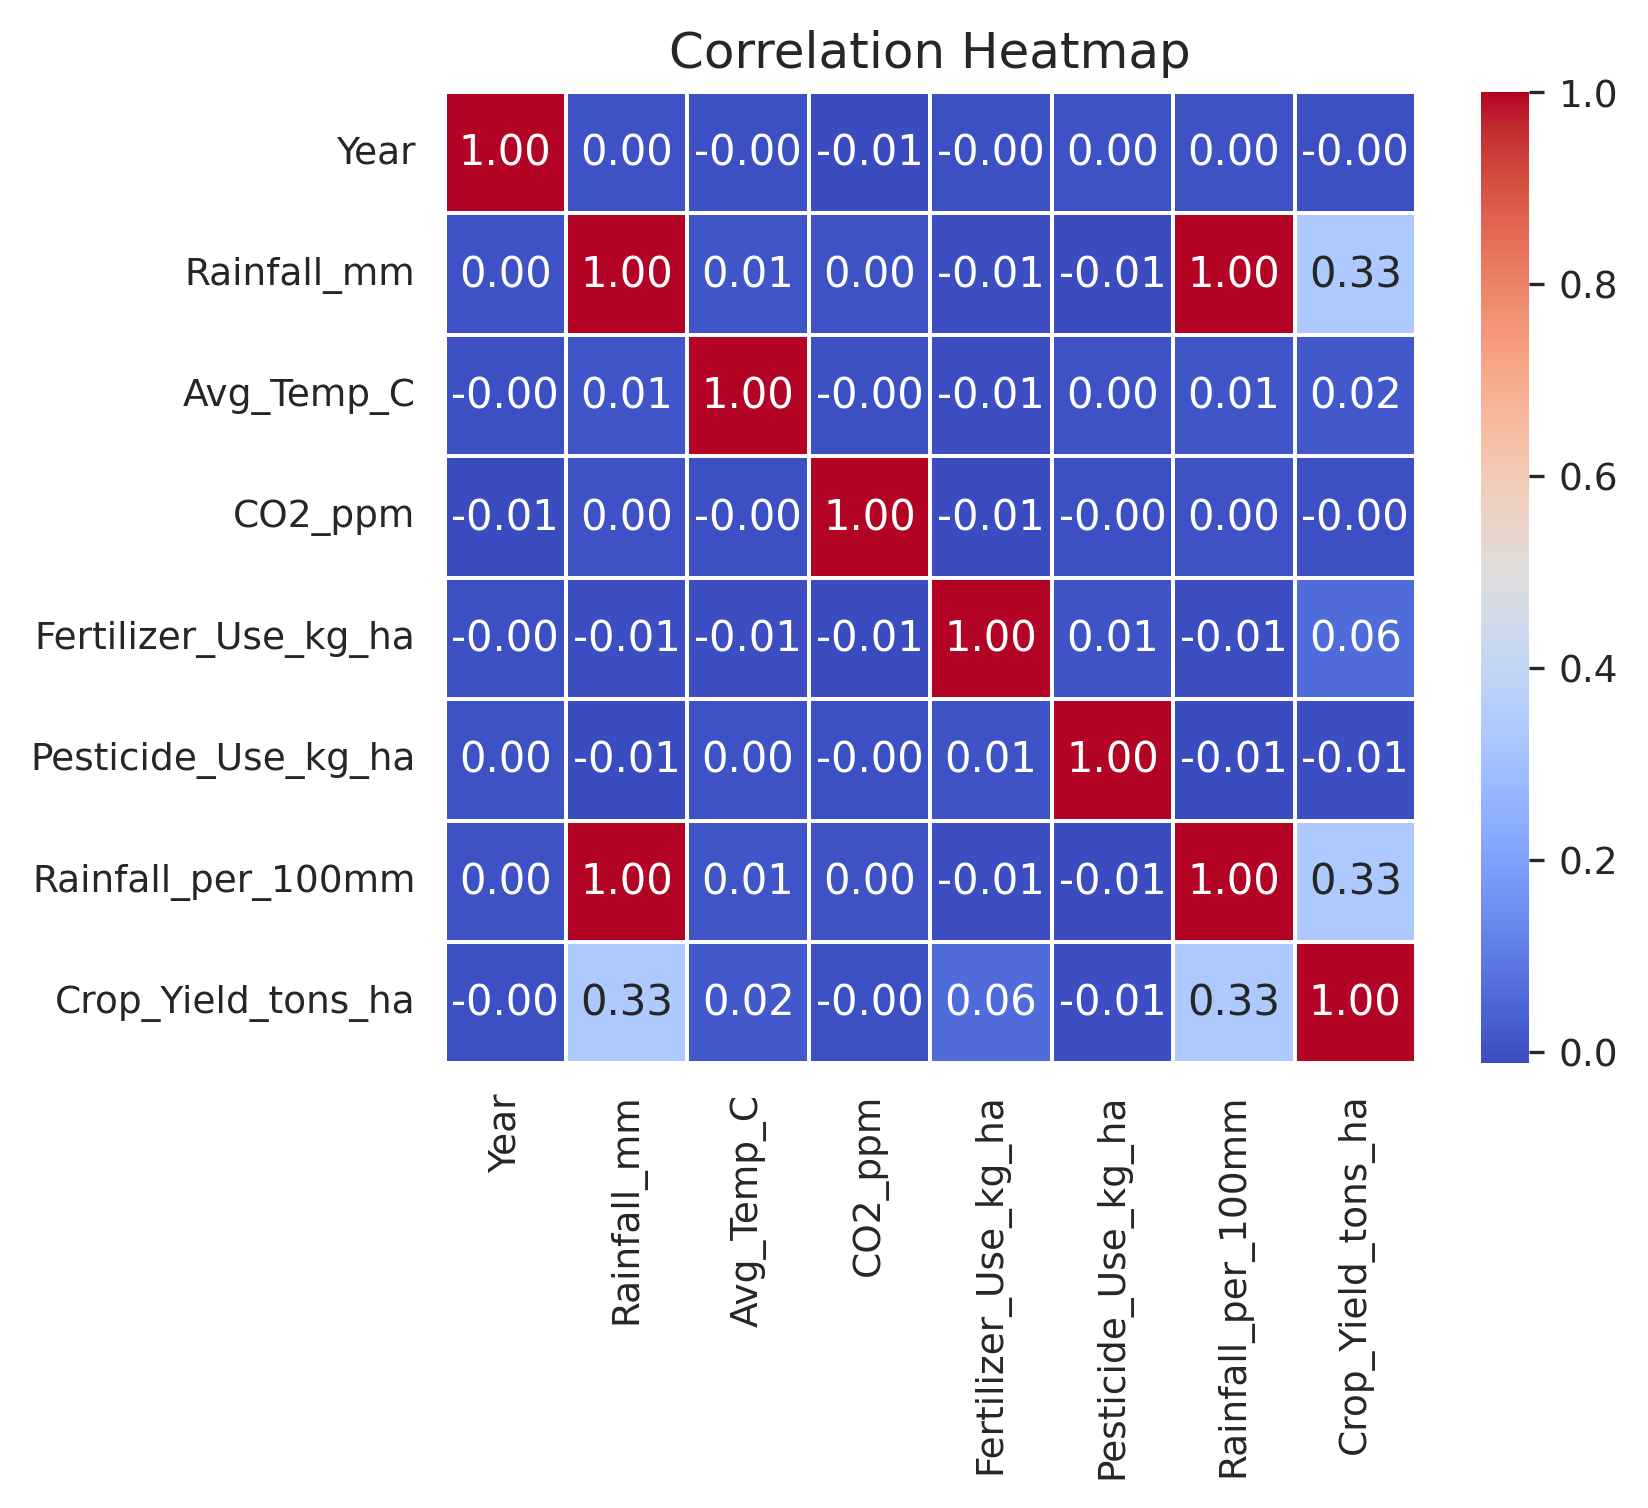

In [1]:
# ================================================================
# 🌾 Complete Interactive Crop Yield Project (IEEE-Style)
# ================================================================

import warnings, os, time, pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Optional interactive widgets
try:
    import ipywidgets as widgets
    from IPython.display import display, clear_output
    WIDGETS=True
except:
    WIDGETS=False

# ================================
# 1) Load dataset
# ================================
DATA_PATH = "/content/controlled_realistic_crop_yield.csv"
df = pd.read_csv(DATA_PATH)
TARGET = "Crop_Yield_tons_ha"

# ================================
# 2) Columns
# ================================
CATEGORICAL_COLS = ["State","Crop","Soil_Type"]
NUMERIC_COLS = ["Year","Rainfall_mm","Avg_Temp_C","CO2_ppm",
                "Fertilizer_Use_kg_ha","Pesticide_Use_kg_ha"]

# Feature engineering
df["Rainfall_per_100mm"] = df["Rainfall_mm"]/100.0
NUMERIC_COLS.append("Rainfall_per_100mm")

# ================================
# 3) Train/Test split
# ================================
X = df[CATEGORICAL_COLS + NUMERIC_COLS]
y = df[TARGET]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.18,random_state=42)

# ================================
# 4) Preprocessor
# ================================
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), CATEGORICAL_COLS),
    ("num", StandardScaler(), NUMERIC_COLS)
])

# ================================
# 5) Models
# ================================
rf_pipe = Pipeline([
    ("pre", preprocessor),
    ("reg", RandomForestRegressor(n_estimators=300,max_depth=14,random_state=42,n_jobs=-1))
])
xgb_pipe = Pipeline([
    ("pre", preprocessor),
    ("reg", XGBRegressor(n_estimators=300,max_depth=5,learning_rate=0.07,
                         objective="reg:squarederror",random_state=42,verbosity=0))
])

# ================================
# 6) Train models
# ================================
start = time.time()
rf_pipe.fit(X_train, y_train)
xgb_pipe.fit(X_train, y_train)
print(f"Training completed in {time.time()-start:.1f}s")

# ================================
# 7) Evaluate & metrics
# ================================
MODELS = {"RandomForest": rf_pipe, "XGBoost": xgb_pipe}
results = {}
preds_store = {}
for name, model in MODELS.items():
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    results[name] = {"R2": r2, "RMSE": rmse, "MAE": mae}
    preds_store[name] = (y_test, y_pred)
    print(f"{name}: R²={r2:.3f}, RMSE={rmse:.3f}, MAE={mae:.3f}")

BEST_NAME = max(results, key=lambda k: results[k]["R2"])
BEST_MODEL = MODELS[BEST_NAME]
print(f"\nBest Model Selected: {BEST_NAME}")

# ================================
# 8) IEEE-style plotting
# ================================
plt.rcParams.update({
    'font.size': 10,
    'font.family': 'Times New Roman',
    'axes.labelsize': 10,
    'axes.titlesize': 12,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 9,
    'figure.dpi': 300
})
sns.set_style("white")

# R² Comparison
plt.figure(figsize=(5,4))
sns.barplot(x=list(results.keys()), y=[v["R2"] for v in results.values()], palette="Blues_r")
plt.ylabel("R² Score")
plt.xlabel("Model")
plt.title("Model Performance Comparison")
plt.tight_layout(); plt.show()

# Predicted vs Actual
y_test_b, y_pred_b = preds_store[BEST_NAME]
plt.figure(figsize=(5,5))
plt.scatter(y_test_b, y_pred_b, alpha=0.6, color='navy', edgecolor='k')
plt.plot([y_test_b.min(), y_test_b.max()], [y_test_b.min(), y_test_b.max()], 'r--', lw=2)
plt.xlabel("Actual Yield (tons/ha)")
plt.ylabel("Predicted Yield (tons/ha)")
plt.title(f"Predicted vs Actual ({BEST_NAME})")
plt.tight_layout(); plt.show()

# Residual Distribution
residuals = y_test_b - y_pred_b
plt.figure(figsize=(5,4))
sns.histplot(residuals, kde=True, color='teal', edgecolor='k')
plt.xlabel("Residuals (tons/ha)")
plt.ylabel("Frequency")
plt.title("Residual Distribution")
plt.tight_layout(); plt.show()

# Feature Importance
try:
    reg = BEST_MODEL.named_steps["reg"]
    pre = BEST_MODEL.named_steps["pre"]
    cat = pre.named_transformers_["cat"]
    cat_names = list(cat.get_feature_names_out(CATEGORICAL_COLS))
    feat_names = cat_names + NUMERIC_COLS
    fi = pd.Series(reg.feature_importances_, index=feat_names).sort_values(ascending=False)

    plt.figure(figsize=(6,6))
    sns.barplot(x=fi.values[:15], y=fi.index[:15], palette="viridis")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.title("Top 15 Feature Importances")
    plt.tight_layout(); plt.show()
except:
    pass

# Correlation Heatmap
plt.figure(figsize=(6,5))
sns.heatmap(df[NUMERIC_COLS+[TARGET]].corr(), annot=True, cmap="coolwarm", fmt=".2f",
            cbar=True, square=True, linewidths=0.5)
plt.title("Correlation Heatmap")
plt.tight_layout(); plt.show()

# ================================
# 9) Dynamic Suggestions & Revenue
# ================================
def suggestions_engine(row):
    S=[]
    # Rainfall
    if row["Rainfall_mm"]<600: S.append("Low rainfall: use drip irrigation and mulch to conserve water.")
    elif row["Rainfall_mm"]>1800: S.append("High rainfall risk: ensure proper drainage to prevent waterlogging.")

    # Temperature
    if row["Avg_Temp_C"]>35: S.append("Use heat-tolerant crop varieties.")
    elif row["Avg_Temp_C"]<15: S.append("Consider cold-hardy varieties or adjust planting time.")

    # Fertilizer
    if row["Fertilizer_Use_kg_ha"]<100: S.append("Apply balanced NPK fertilizer based on soil test.")
    else: S.append("Fertilizer application adequate; monitor soil health.")

    # Pesticide
    if row["Pesticide_Use_kg_ha"]>5: S.append("Adopt integrated pest management (IPM).")
    else: S.append("Pest control within safe limits.")

    # Generic agronomy
    S.append("Increase soil organic matter through compost or green manure.")
    S.append("Adopt precision agriculture for variable-rate inputs.")
    S.append("Regularly monitor pests, diseases, and crop health.")
    S.append("Practice crop rotation and sustainable agriculture.")
    S.append("Improve post-harvest handling to reduce losses.")
    S.append("Consider crop insurance and risk management strategies.")
    return S[:10]

def predict_single(state, crop, soil, numeric_inputs, price_per_ton=1000, area_ha=1):
    row = {**{"State":state,"Crop":crop,"Soil_Type":soil}, **numeric_inputs}
    row["Rainfall_per_100mm"] = row["Rainfall_mm"]/100.0
    df_row = pd.DataFrame([row])[CATEGORICAL_COLS + NUMERIC_COLS]
    pred = float(BEST_MODEL.predict(df_row)[0])
    revenue = pred * price_per_ton * area_ha
    return pred, revenue, suggestions_engine(row)

# ================================
# 10) Interactive UI
# ================================
if WIDGETS:
    state_w = widgets.Dropdown(options=df["State"].dropna().unique(), description="State:")
    crop_w = widgets.Dropdown(options=df["Crop"].dropna().unique(), description="Crop:")
    soil_w = widgets.Dropdown(options=df["Soil_Type"].dropna().unique(), description="Soil:")

    numeric_widgets = {}
    for c in NUMERIC_COLS:
        lo, hi = df[c].min(), df[c].max()
        numeric_widgets[c] = widgets.FloatSlider(
            value=float(df[c].median()), min=lo, max=hi, step=(hi-lo)/100, description=c
        )

    price_w = widgets.FloatText(value=1000, description="Price/ton:")
    area_w = widgets.FloatText(value=1, description="Area (ha):")

    predict_btn = widgets.Button(description="Predict & Suggest", button_style="success")
    out = widgets.Output()

    display(widgets.VBox(
        [widgets.HBox([state_w,crop_w,soil_w])] +
        [widgets.HBox(list(numeric_widgets.values())[i:i+3]) for i in range(0,len(NUMERIC_COLS),3)] +
        [widgets.HBox([price_w,area_w]), predict_btn, out]
    ))

    def on_predict(b):
        with out:
            clear_output()
            numeric_inputs = {c:w.value for c,w in numeric_widgets.items()}
            pred, revenue, sugg = predict_single(
                state_w.value, crop_w.value, soil_w.value,
                numeric_inputs, price_per_ton=price_w.value, area_ha=area_w.value
            )
            print(f"🏷️ Predicted Crop Yield: {pred:.3f} tons/ha")
            print(f"💰 Estimated Revenue: ₹{revenue:,.0f}")
            print("\nTop Suggestions to Improve Yield:")
            for i,s in enumerate(sugg,1): print(f"{i}. {s}")
            print("\nModel Performance on Holdout Set:")
            for n,v in results.items():
                print(f" - {n}: R²={v['R2']:.3f}, RMSE={v['RMSE']:.3f}, MAE={v['MAE']:.3f}")

    predict_btn.on_click(on_predict)

else:
    print("Widgets not available. Use `predict_single(state,crop,soil,numeric_inputs, price_per_ton, area_ha)` programmatically.")
